# BD RIS IMPLEMENTATION (MULTI SECTOR MODE)

In [1]:
# Importing all libraries

import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Functions import *

In [2]:
#============== System parameters
'''
Defining Parameters
    Nt = Number of transmit antennas (SISO = 1)
    K = Number of Users
    BW = Bandwidth
    NF = Noise Floor
    ALPHA = PLE for indirect link (IRS-1)
    BETA = PLE for indirect link (IRS-2)
    ZETA = PLE for direct link 
    wn = efficiency of transmit power amplifier
    Pb = Power dissipated by BS
    Pu = Power dissipated by User
    loc_U = User positions
    m = Nakagami Shape parameter (m > 0, m = 1 corresponds to Rayleigh fading)
    omega = 1.0  Nakagami Spread parameter (omega > 0)
    Ns_max = Total number of IRS elements in a single IRS

'''
# Initialize constants
Nt = 1
f = 2.4e9
c = 3e8
Lambda = c / f
halfLambda = 0.5 * Lambda
quarterLambda = 0.25 * Lambda
BW = 20e6
NF = 10
noise = -174 + 10*np.log10(BW) + NF

# Network Parameters
BASE_STATION_POSITION = (0, 0, 35)
dThreshold = 50  # Replace GRID_RADIUS with appropriate value / 40
RATE_THRESHOLD = 25

# IRS Position
IRS_position = (50, 86.60, 10)

# IRS elements and dimensions
L = 1 # Number of faces for the IRS (change this for different polygons)
M = 360 // L
nIRSrow = M // 6
nIRScol = M // nIRSrow
edge_length = 5  # Length of each edge of the IRS in meters
z_height = edge_length  # Fixed height equal to edge_length

# NOMA CELLS BEGIN

In [40]:
#============== System parameters
'''
Defining Parameters
    Nt = Number of transmit antennas (SISO = 1)
    K = Number of Users
    BW = Bandwidth
    NF = Noise Floor
    ALPHA = PLE for indirect link (IRS-1)
    BETA = PLE for indirect link (IRS-2)
    ZETA = PLE for direct link 
    wn = efficiency of transmit power amplifier
    Pb = Power dissipated by BS
    Pu = Power dissipated by User
    loc_U = User positions
    m = Nakagami Shape parameter (m > 0, m = 1 corresponds to Rayleigh fading)
    omega = 1.0  Nakagami Spread parameter (omega > 0)
    Ns_max = Total number of IRS elements in a single IRS

'''
# Initialize constants
Nt = 1
f = 2.4e9
c = 3e8
Lambda = c / f
halfLambda = 0.5 * Lambda
quarterLambda = 0.25 * Lambda
BW = 20e6
NF = 10
noise = -174 + 10*np.log10(BW) + NF

# Network Parameters
BASE_STATION_POSITION = (0, 0, 20)
dThreshold = 50  # Replace GRID_RADIUS with appropriate value / 40
RATE_THRESHOLD = 0.25

# IRS Position
IRS_position = (10, 10, 5)

# IRS elements and dimensions
L = 1 # Number of faces for the IRS (change this for different polygons)
M = 360 // L
nIRSrow = M // 6
nIRScol = M // nIRSrow
edge_length = 5  # Length of each edge of the IRS in meters
z_height = edge_length  # Fixed height equal to edge_length

# Assuming previous code parts
radius = 100  # Range for generation of users within IRS
USER_POS = np.array([[30, 30, 1], [50, 50, 1]])
K = len(USER_POS)
locU = USER_POS 
xt, yt, zt = BASE_STATION_POSITION  # Coordinates of BS
locT = np.array([BASE_STATION_POSITION])  # Position of BS

coordinates, vertices, face_midpoints = generate_all_irs_coordinates(IRS_position, L, nIRSrow, nIRScol, edge_length, z_height)
dTU, dSU, dTS, closest_face_indices = calculate_distances_3D(USER_POS, locT, face_midpoints, IRS_position, L)

# Generate circle and sectors data for plotting
x_circle, y_circle, z_circle, sector_lines = generate_circle_and_sectors_3D(BASE_STATION_POSITION, radius, L)

# Compute path gains and channels
GTU, GSU, GTS = compute_path_gains(dTU, dSU, dTS, M)

# Different values of L (number of IRS faces) to simulate
NUM_SIMULATIONS = 100
Pt = np.arange(0, 41, 0.1)  # in dBm

# Variables declared
outage_probability_disc = np.zeros((NUM_SIMULATIONS, K))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS, K))
arr_lb_disc = np.zeros((NUM_SIMULATIONS, K))

average_SNR_1 = []

# Generate large scale fading coefficients once
alpha_kl = generate_large_scale_fading_new(dTS, dSU, L, K, closest_face_indices)

# Take the maximum value in each row of alpha_kl to create a matrix of (K, 1)
alpha_kl_new = np.max(alpha_kl, axis=1).reshape(K, 1)

# Initialize arrays to store results for each L value
h_dk_3d = np.zeros((NUM_SIMULATIONS, K, 1), dtype=np.complex128)
h_rk1_3d = np.zeros((NUM_SIMULATIONS, M, K), dtype=np.complex128)
h_rk1_h_3d = np.zeros((NUM_SIMULATIONS, K, M), dtype=np.complex128)
G1_3d = np.zeros((NUM_SIMULATIONS, L, M), dtype=np.complex128)

# Perform simulations
for i in range(NUM_SIMULATIONS):
    # Compute channels
    hTU, hSU, hTS = compute_channels_NOMA(GTU, GSU, GTS, K, L, M, K_factor=10)

    # Store results for each simulation
    h_dk_3d[i] = hTU  # BS to users
    h_rk1_3d[i] = hSU  # IRS to users
    h_rk1_h_3d[i] = np.conj(np.transpose(hSU))  # Transpose IRS to users
    G1_3d[i] = hTS  # BS to all IRS faces and their elements

for T in Pt:
    # Converting the dBm power to watts for further use
    TRANSMIT_POWER_WATTS = dBm2pow(T)

    # Initialize sum-rates for this case
    SNR = []

    # Perform simulations
    for s in range(NUM_SIMULATIONS):
        h_dk = h_dk_3d[s]  # Shape: (K, 1)
        h_rk = h_rk1_3d[s]  # Shape: (M, K)
        h_rk_transpose = h_rk1_h_3d[s]  # Shape: (K, M)
        G = G1_3d[s]  # Shape: (L, M)

        # Compute theta and product matrix
        theta = theta_matrix_ideal(1, h_dk, h_rk, G, K, M, L)
        results_array = prod_matrix(theta, h_rk_transpose, G, K, M, L, closest_face_indices)

        # Calculate sum rate
        arr_link_budget = np.abs((TRANSMIT_POWER_WATTS * alpha_kl_new)**0.5 * (h_dk + results_array))
        arr_link_budget = pow2dBm((arr_link_budget)**2)
        arr_SNR_disc[s, :] = compute_SNR_NOMA(arr_link_budget, noise).flatten()
        SNR.append(arr_SNR_disc[s])

    # Calculate average sum rate across simulations for this Pt
    average_SNR_1.append(np.mean(SNR, axis=0))

# Convert list to numpy array
average_SNR_1 = np.array(average_SNR_1)
average_SNR_1 = average_SNR_1.reshape(K, len(Pt))

In [41]:
print(np.shape(average_SNR_1))

#Compute mean SNR for each row
mean_SNR = (np.mean(average_SNR_1, axis=1))

print(np.shape(mean_SNR))

# Determine which row corresponds to SNR1 and SNR2 based on mean SNR
if mean_SNR[0] > mean_SNR[1]:
    SNR1 = average_SNR_1[0, :]
    SNR2 = average_SNR_1[1, :]
else:
    SNR1 = average_SNR_1[1, :]
    SNR2 = average_SNR_1[0, :]

a = 0.3  # Power allocation coefficient for user 1

# Compute rates
R2 = np.log2(1 + (1-a) * SNR2 / (a * SNR2 + 1))
R1 = np.log2(1 + a * SNR1)

print(np.shape(R1))
print(np.shape(R2))

(2, 410)
(2,)
(410,)
(410,)


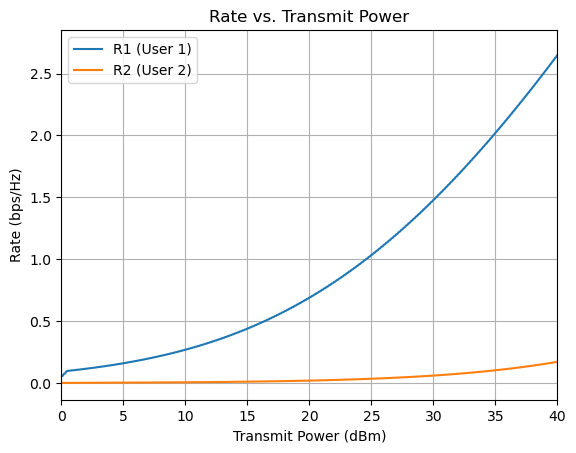

In [42]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

window_size = 10  # Window size for moving average

# Apply moving average for smoothing
R1 = moving_average(R1, window_size)
R2 = moving_average(R2, window_size)

# Plotting
plt.plot(Pt, R1, label='R1 (User 1)')
plt.plot(Pt, R2, label='R2 (User 2)')
plt.xlabel('Transmit Power (dBm)')
plt.ylabel('Rate (bps/Hz)')
plt.title('Rate vs. Transmit Power')
plt.xlim(0,40)
plt.legend()
plt.grid(True)
plt.show()

# NOMA CELLS END

In [51]:
# Assuming previous code parts
radius = 30  # Range for generation of users within IRS
K = 2  # Number of users
USER_POS = generate_fixed_user_positions(K, radius, IRS_position)
locU = USER_POS 
xt, yt, zt = BASE_STATION_POSITION  # Coordinates of BS
locT = np.array([BASE_STATION_POSITION])  # Position of BS

L = 5 # Example value for L
M = 360 // L
nIRSrow = M // 6
nIRScol = M // nIRSrow
coordinates, vertices, face_midpoints = generate_all_irs_coordinates(IRS_position, L, nIRSrow, nIRScol, edge_length, z_height)
dTU, dSU, dTS, ci = calculate_distances_3D(USER_POS, locT, face_midpoints, IRS_position, L)

# Generate circle and sectors data for plotting
x_circle, y_circle, z_circle, sector_lines = generate_circle_and_sectors_3D(IRS_position, radius, L)


# # Compute path gains
GTU, GSU, GTS = compute_path_gains(dTU, dSU, dTS, M)

# hTU, hSU, hTS = compute_channels(GTU, GSU, GTS, K, L, M, K_factor=10)

# print("Channel shape between users and BS:", np.shape(hTU))
# print("Channel shape between users and closest IRS faces:", np.shape(hSU))
# print("Channel shape between BS and all IRS faces:", np.shape(hTS))
# print()
# # print("Channels between users and BS:", (hTU))
# # print("Channels between users and closest IRS faces:", (hSU))
# # print("Channels between BS and all IRS faces:", (hTS))
# print("Distance shape between users and BS:", np.shape(dTU))
# print("Distance shape between users and closest IRS faces:", np.shape(dSU))
# print("Distance shape between BS and all IRS faces:", np.shape(dTS))
# print()
# print("Distances between users and BS:\n", dTU)
# print("Distances between users and closest IRS faces:\n", dSU)
# print("Distances between BS and all IRS faces:\n", dTS)

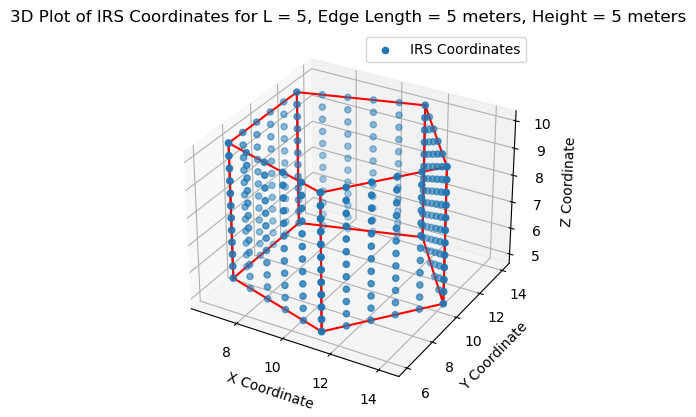

In [52]:
# Plotting the coordinates in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], label='IRS Coordinates')

# Plot the edges of the faces (only top and bottom edges)
plot_edges(ax, vertices, nIRSrow, z_height)

# Setting labels
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title(f'3D Plot of IRS Coordinates for L = {L}, Edge Length = {edge_length} meters, Height = {z_height} meters')
plt.legend()
plt.show()

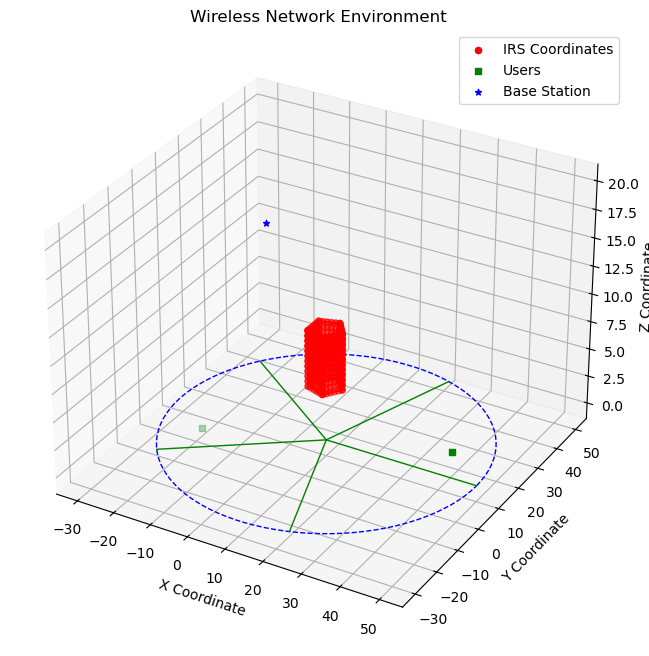

[0 2]


In [53]:
# Plotting in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot IRS coordinates
ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], color='red', label='IRS Coordinates')

# Plot the edges of the faces (only top and bottom edges)
plot_edges(ax, vertices, nIRSrow, z_height)

# Plot wireless network environment
ax.scatter3D(USER_POS[:, 0], USER_POS[:, 1], USER_POS[:, 2], color='green', marker='s', label='Users')
ax.scatter(xt, yt, zt, color='blue', marker='*', label='Base Station')

# Plot the circle in the XY plane
ax.plot3D(x_circle, y_circle, z_circle, 'b--', linewidth=1)

# Plot the sector lines
for line in sector_lines:
    (x_start, y_start, z_start), (x_end, y_end, z_end) = line
    ax.plot3D([x_start, x_end], [y_start, y_end], [z_start, z_end], 'g-', linewidth=1)

# Setting labels and title
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('Wireless Network Environment')
ax.legend()
plt.show()

print(ci)

In [11]:
# Number of Simulations
NUM_SIMULATIONS = 1000

# Initialize arrays to store results
h_dk_3d = np.zeros((NUM_SIMULATIONS, K, 1), dtype=np.complex128)
h_rk1_3d = np.zeros((NUM_SIMULATIONS, M, K), dtype=np.complex128)
h_rk1_h_3d = np.zeros((NUM_SIMULATIONS, K, M), dtype=np.complex128)
G1_3d = np.zeros((NUM_SIMULATIONS, L, M), dtype=np.complex128)

# Perform simulations
for i in range(NUM_SIMULATIONS):
    # Compute channels
    hTU, hSU, hTS = compute_channels_NOMA(GTU, GSU, GTS, K, L, M, K_factor = 10)
    
    # Store results for each simulation
    h_dk_3d[i] = hTU # BS to users
    h_rk1_3d[i] = hSU # IRS to users
    h_rk1_h_3d[i] = np.conj(np.transpose(hSU)) # Transpose IRS to users
    G1_3d[i] = hTS # BS to all IRS faces and their elements

# Print sizes of generated arrays
print('Size of h_dk_3d:', np.shape(h_dk_3d)) # Shape: (NUM_SIMULATIONS, K, 1)
print('Size of h_rk1_3d:', np.shape(h_rk1_3d)) # Shape: (NUM_SIMULATIONS, M, K)
print('Size of h_rk1_h_3d:', np.shape(h_rk1_h_3d)) # Shape: (NUM_SIMULATIONS, K, M)
print('Size of G1_3d:', np.shape(G1_3d)) # Shape: (NUM_SIMULATIONS, L, M)

Size of h_dk_3d: (1000, 2, 1)
Size of h_rk1_3d: (1000, 360, 2)
Size of h_rk1_h_3d: (1000, 2, 360)
Size of G1_3d: (1000, 1, 360)


In [54]:
# Initialize constants
Nt = 1
K = 6
f = 2.4e9
c = 3e8
Lambda = c / f
halfLambda = 0.5 * Lambda
quarterLambda = 0.25 * Lambda
BW = 10e6
NF = 10
noise = -174 + 10 * np.log10(BW) + NF

# Constants for large scale fading 
Gt = 1
Gr = 1
eta_RIS = 2
eta_kl = 2

# Network Parameters
BASE_STATION_POSITION = (0, 0, 35)
dThreshold = 50  # Replace GRID_RADIUS with appropriate value / 40
RATE_THRESHOLD = 0.25

# IRS Position
IRS_position = (50, 86.60, 10)
# IRS_position = (70, 106.60, 0)

# IRS elements and dimensions
edge_length = 10  # Length of each edge of the IRS in meters
z_height = edge_length  # Fixed height equal to edge_length

# Generate Users and Number of IRS Faces
radius = 30  # Range for generation of users within IRS
USER_POS = generate_fixed_user_positions(K, radius, IRS_position)
locU = USER_POS
xt, yt, zt = BASE_STATION_POSITION  # Coordinates of BS
locT = np.array([BASE_STATION_POSITION])  # Position of BS

# Different values of L (number of IRS faces) to simulate
NUM_SIMULATIONS = 1000
L_max = 6
L_values = np.array([i for i in range(2, L_max + 1)])  # Example values, adjust as needed
Pt = np.arange(0, 51, 5)  # in dBm

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS, 1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS, K, 1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS, K, 1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS, K, 1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS, K, 1))

# Initialize an empty dictionary to store the results
results_dict_1 = {}

for L in L_values:
    average_spectral_efficiency_1 = []

    # Ensure L*M = 360
    M = 360 // L
    nIRSrow = M // 6
    nIRScol = M // nIRSrow

    # Generate IRS coordinates, vertices, and face midpoints for the current L
    coordinates, vertices, face_midpoints = generate_all_irs_coordinates(IRS_position, L, nIRSrow, nIRScol, edge_length, z_height)

    # Calculate distances for IRS and determine the closest face for each user
    dTU, dSU, dTS, closest_face_indices = calculate_distances_3D(USER_POS, locT, face_midpoints, IRS_position, L)

    # Generate large scale fading coefficients once
    alpha_kl = generate_large_scale_fading(dTS, dSU, Gt, Gr, Lambda, L, eta_RIS, eta_kl, K, closest_face_indices)

    # Take the maximum value in each row of alpha_kl to create a matrix of (K, 1)
    alpha_kl_new = np.max(alpha_kl, axis=1).reshape(K, 1)

    # Initialize arrays to store results for each L value
    h_dk_3d = np.zeros((NUM_SIMULATIONS, K, 1), dtype=np.complex128)
    h_rk1_3d = np.zeros((NUM_SIMULATIONS, M, K), dtype=np.complex128)
    h_rk1_h_3d = np.zeros((NUM_SIMULATIONS, K, M), dtype=np.complex128)
    G1_3d = np.zeros((NUM_SIMULATIONS, L, M), dtype=np.complex128)

    # Perform simulations
    for i in range(NUM_SIMULATIONS):
        # Compute channels
        hTU, hSU, hTS = compute_channels(K, L, M, K_factor=10)

        # Store results for each simulation
        h_dk_3d[i] = hTU  # BS to users
        h_rk1_3d[i] = hSU  # IRS to users
        h_rk1_h_3d[i] = np.conj(np.transpose(hSU))  # Transpose IRS to users
        G1_3d[i] = hTS  # BS to all IRS faces and their elements

    for T in Pt:
        # Converting the dBm power to watts for further use
        TRANSMIT_POWER_WATTS = dBm2pow(T)

        # Initialize sum-rates for this case
        spectral_efficiency = []

        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s]  # Shape: (K, 1)
            h_rk = h_rk1_3d[s]  # Shape: (M, K)
            h_rk_transpose = h_rk1_h_3d[s]  # Shape: (K, M)
            G = G1_3d[s]  # Shape: (L, M)

            # Compute theta and product matrix
            theta = theta_matrix_ideal(1, h_dk*0, h_rk, G, K, M, L)
            results_array = prod_matrix(theta, h_rk_transpose, G, K, M, L, closest_face_indices)

            # Calculate sum rate
            arr_link_budget = np.abs((TRANSMIT_POWER_WATTS * alpha_kl_new)**0.5 * (h_dk*0 + results_array))
            arr_link_budget = pow2dBm((arr_link_budget)**2)
            arr_SNR_disc[s, :, :] = compute_SNR(arr_link_budget, noise)
            arr_rate_disc[s, :, :] = compute_rate(arr_SNR_disc[s, :, :])
            outage_probability_disc[s, :, :] = compute_outage_probability(K, arr_rate_disc[s, :, :], RATE_THRESHOLD)
            arr_sumrate_disc[s] = np.sum(arr_rate_disc[s, :, :])
            spectral_efficiency.append(arr_sumrate_disc[s]/K)

        # Calculate average sum rate across simulations for this Pt
        average_spectral_efficiency_1.append(np.mean(spectral_efficiency))

    # Store average sum rate for this L in the results dictionary
    results_dict_1[L] = average_spectral_efficiency_1

print('done')
print(L_values)

done
[2 3 4 5 6]


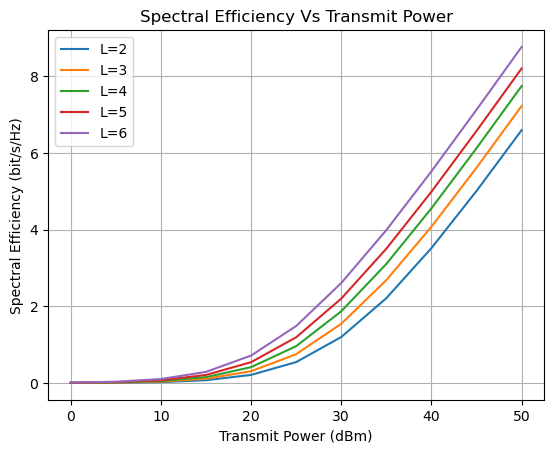

In [57]:
for L, average_spectral_efficiency_1 in results_dict_1.items():
    plt.plot(Pt, average_spectral_efficiency_1, label=f'L={L}')
    
plt.ylabel('Spectral Efficiency (bit/s/Hz)')
plt.xlabel('Transmit Power (dBm)')
plt.title('Spectral Efficiency Vs Transmit Power')
plt.legend()
plt.grid(True)

# Setting the y-axis limit
# plt.ylim(0, 6)

plt.show()

In [59]:
# Initialize constants
Nt = 1
K = 6
f = 2.4e9
c = 3e8
Lambda = c / f
halfLambda = 0.5 * Lambda
quarterLambda = 0.25 * Lambda
BW = 10e6
NF = 10
noise = -174 + 10 * np.log10(BW) + NF

# Constants for large scale fading 
Gt = 1
Gr = 1
eta_RIS = 2
eta_kl = 2

# Network Parameters
BASE_STATION_POSITION = (0, 0, 35)
dThreshold = 50  # Replace GRID_RADIUS with appropriate value / 40
RATE_THRESHOLD = 25

# IRS Position
IRS_position = (50, 86.60, 10)
# IRS_position = (70, 106.60, 0)

# IRS elements and dimensions
edge_length = 10  # Length of each edge of the IRS in meters
z_height = edge_length  # Fixed height equal to edge_length

# Generate Users and Number of IRS Faces
radius = 30  # Range for generation of users within IRS
USER_POS = generate_fixed_user_positions(K, radius, IRS_position)
locU = USER_POS
xt, yt, zt = BASE_STATION_POSITION  # Coordinates of BS
locT = np.array([BASE_STATION_POSITION])  # Position of BS

# Different values of L (number of IRS faces) to simulate
NUM_SIMULATIONS = 1000
L_max = 6
L_values = np.array([i for i in range(2, L_max + 1)])  # Example values, adjust as needed
Pt = np.arange(0, 51, 5)  # in dBm

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS, 1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS, K, 1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS, K, 1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS, K, 1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS, K, 1))

# Function to run simulations and return the results
def run_simulations(K_factor, eta_RIS, eta_kl):
    results_dict = {}
    
    for L in L_values:
        average_spectral_efficiency = []

        # Ensure L*M = 360
        M = 360 // L
        nIRSrow = M // 6
        nIRScol = M // nIRSrow

        # Generate IRS coordinates, vertices, and face midpoints for the current L
        coordinates, vertices, face_midpoints = generate_all_irs_coordinates(IRS_position, L, nIRSrow, nIRScol, edge_length, z_height)

        # Calculate distances for IRS and determine the closest face for each user
        dTU, dSU, dTS, closest_face_indices = calculate_distances_3D(USER_POS, locT, face_midpoints, IRS_position, L)

        # Generate large scale fading coefficients once
        alpha_kl = generate_large_scale_fading(dTS, dSU, Gt, Gr, Lambda, L, eta_RIS, eta_kl, K, closest_face_indices)

        # Take the maximum value in each row of alpha_kl to create a matrix of (K, 1)
        alpha_kl_new = np.max(alpha_kl, axis=1).reshape(K, 1)

        # Initialize arrays to store results for each L value
        h_dk_3d = np.zeros((NUM_SIMULATIONS, K, 1), dtype=np.complex128)
        h_rk1_3d = np.zeros((NUM_SIMULATIONS, M, K), dtype=np.complex128)
        h_rk1_h_3d = np.zeros((NUM_SIMULATIONS, K, M), dtype=np.complex128)
        G1_3d = np.zeros((NUM_SIMULATIONS, L, M), dtype=np.complex128)

        # Perform simulations
        for i in range(NUM_SIMULATIONS):
            # Compute channels
            hTU, hSU, hTS = compute_channels(K, L, M, K_factor)

            # Store results for each simulation
            h_dk_3d[i] = hTU  # BS to users
            h_rk1_3d[i] = hSU  # IRS to users
            h_rk1_h_3d[i] = np.conj(np.transpose(hSU))  # Transpose IRS to users
            G1_3d[i] = hTS  # BS to all IRS faces and their elements

        for T in Pt:
            # Converting the dBm power to watts for further use
            TRANSMIT_POWER_WATTS = dBm2pow(T)

            # Initialize sum-rates for this case
            spectral_efficiency = []

            # Perform simulations
            for s in range(NUM_SIMULATIONS):
                h_dk = h_dk_3d[s]  # Shape: (K, 1)
                h_rk = h_rk1_3d[s]  # Shape: (M, K)
                h_rk_transpose = h_rk1_h_3d[s]  # Shape: (K, M)
                G = G1_3d[s]  # Shape: (L, M)

                # Compute theta and product matrix
                theta = theta_matrix_ideal(1, h_dk*0, h_rk, G, K, M, L)
                results_array = prod_matrix(theta, h_rk_transpose, G, K, M, L, closest_face_indices)

                # Calculate sum rate
                arr_link_budget = np.abs((TRANSMIT_POWER_WATTS * alpha_kl_new)**0.5 * (h_dk*0 + results_array))
                arr_link_budget = pow2dBm((arr_link_budget)**2)
                arr_SNR_disc[s, :, :] = compute_SNR(arr_link_budget, noise)
                arr_rate_disc[s, :, :] = compute_rate(arr_SNR_disc[s, :, :])
                outage_probability_disc[s, :, :] = compute_outage_probability(K, arr_rate_disc[s, :, :], RATE_THRESHOLD)
                arr_sumrate_disc[s] = np.sum(arr_rate_disc[s, :, :])
                spectral_efficiency.append(arr_sumrate_disc[s]/K)

            # Calculate average sum rate across simulations for this Pt
            average_spectral_efficiency.append(np.mean(spectral_efficiency))

        # Store average sum rate for this L in the results dictionary
        results_dict[L] = average_spectral_efficiency
    
    return results_dict

# Run simulations for K_factor = 10, eta = 2
results_k10_eta2 = run_simulations(10, eta_RIS=2, eta_kl=2)

# Run simulations for K_factor = 0, eta = 3
results_k0_eta3 = run_simulations(5, eta_RIS=2.5, eta_kl=2.5)

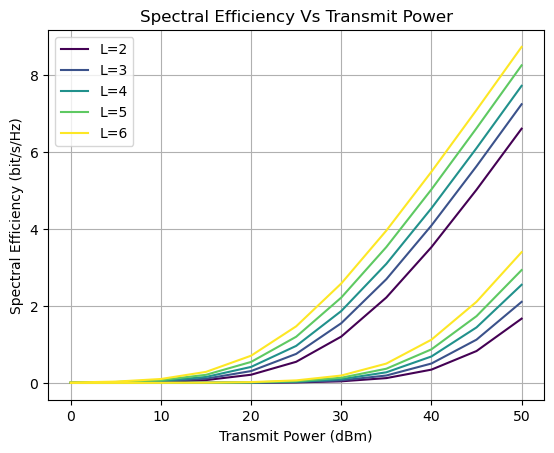

In [60]:
# Define colors for different values of L
colors = plt.cm.viridis(np.linspace(0, 1, len(L_values)))

# Plot the results on the same figure
for idx, L in enumerate(L_values):
    plt.plot(Pt, results_k10_eta2[L], label=f'L={L}', linestyle='-', color=colors[idx])
    plt.plot(Pt, results_k0_eta3[L], linestyle='-', color=colors[idx])

plt.ylabel('Spectral Efficiency (bit/s/Hz)')
plt.xlabel('Transmit Power (dBm)')
plt.title('Spectral Efficiency Vs Transmit Power')
plt.legend()
plt.grid(True)
# plt.ylim(0, 1.5)
plt.show()